# Assignment Task for Data Scientists #

## Introduction ##

You are a Data Scientist working at upday, a news aggregator and recommender.

The engineering team at upday is gathering on a regular basis articles from all the Web. In order to provide a proper filtering functionality in the app, the articles need to be categorized.

You have at your disposal a pre-labelled dataset that maps different articles and their metadata to a specific category.

It's up to you now to help the company providing a solution for automatically categorizing articles.

## Assignment ##

The repository contains a dataset with some english articles and some information about them:

* category
* title
* text
* url

The purpose of the task is to provide a classification model for the articles.

## Instructions ##

You should make a pull request to this repository containing the solution. If you need to clarify any point of your solution, please include an explanation in the PR description.

What we expect:

* Explanation about the solution you adopted and the results from your data exploration
* Documentation of the results of your model, including the metrics adopted and the final evaluation
* The training and evaluation code

The solution should just perform better than random, also we expect you to use model that is not just rules-based.

How to present the documentation and the code is up to you, whether to provide one or more jupyter notebooks or via a different mean.

## Bonus ##

Scripts to be run from the command line:

* A script for training the dataset
* A script for evaluating the dataset
* A script to infer the category given an article

<br>
<br>
<br>
<br>
<br>

## Let's begin! ##

### Imports ###

In [1]:
import re
import spacy
import unicodedata
import pandas as pd
import numpy as np
import tensorflow as tf
from contractions import CONTRACTION_MAP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from tensorflow.keras import models, layers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt

### Prepare the Functionality of the NLP Libraries ###

In [2]:
nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

<br>
<br>
First, we load the dataset:

In [3]:
df = pd.read_csv("C:/Upday-Homework/data_redacted.tsv", sep="\t")

<br>
<br>
Let's inspect the first few rows of the data frame:

In [4]:
df.head()

,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle


<br>
<br>
First thing's first - let's take a look at the distribution of the categories:

In [5]:
df['category'].value_counts()

fashion_beauty_lifestyle    1398
sports                      1165
technology_science          1040
digital_life                 738
money_business               733
news                         646
music                        568
culture                      547
travel                       544
cars_motors                  470
politics                     430
people_shows                 367
Name: category, dtype: int64

<br>
<br>
We can also plot these, as percentages, to get a better view of the overall distribution:

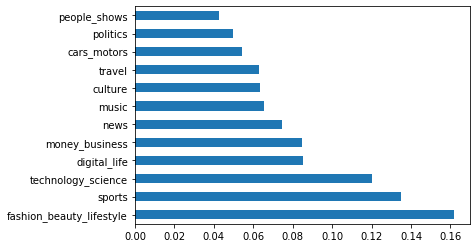

In [6]:
df['category'].value_counts(normalize=True).plot(kind='barh')

<br>
<br>
We've got 12 categories in total. Fashine, sports and technology seem to be the most common ones. A very important note here, for the ML modeling later - we'll need to make sure we stratify on the "category" column when we perform a train/test split, in order to preserve the distribution in the training and testing set as much as possible.

<br>
<br>

## Text Pre-Processing ##

What we have right now is raw text of the articles. But we can't just use it as-is. We need to preprocess it, clean it, and then engineer features based on it.

There are a number of text pre-processing tasks that can be done:


* **Cleaning Text**
* **Tokenizing Text**
* **Removing Special Characters**
* **Expanding Contractions**
* **Case Conversions**
* **Removing Stopwords**
* **Correcting Words**
* **Stemming**
* **Lemmatization**

On top of these processing and cleaning tasks, we'll perform feature engineering later.
<br>
<br>

### Removing Accented Characters ###

Usually in any text corpus, you might be dealing with accented characters/letters, especially if you only want to analyze the English language. Hence, we need to make sure that these characters are converted and standardized into ASCII characters. A simple example — converting é to e.

In [7]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

<br>
<br>

### Expanding Contractions ###



Contractions are shortened version of words or syllables. They exist in either written or spoken forms. Shortened versions of existing words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. An exemple of an expanded contraction would be the conversion of "should've" into should have.

By nature, contractions do pose a problem for NLP and text analytics because, to start with, we have a special apostrophe character in the word. Ideally, we can have a proper mapping for contractions and their corresponding expansions and then use it to expand all the contractions in our text.

The Python libaries we'll be using in this project don't have native support for contractions. Instead, we rely on a list of contractions provided by Dipanjan Sarkar on his [GitHub](https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py). We've also included the **contractions.py** file together with this project.

In [8]:
def expand_contractions(text):
    
    contractions_pattern = re.compile('({})'.format('|'.join(CONTRACTION_MAP.keys())),flags=re.IGNORECASE|re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = CONTRACTION_MAP.get(match)\
                        if CONTRACTION_MAP.get(match)\
                        else CONTRACTION_MAP.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    
    return expanded_text

<br>
<br>

### Removing Special Characters ###

One important task in text normalization involves removing unnecessary and special characters. These may be special symbols or even punctuation that occurs in sentences. This step is often performed before or after tokenization. The main reason for doing so is because often punctuation or special characters do not have much significance when we analyze the text and utilize it for extracting features or information based on NLP and ML. We'also remove digits by default.

In [9]:
def remove_special_characters(text, remove_digits=True):
    text.strip()
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

<br>
<br>

### Removing Stopwords ###

_Stopwords_ are words that have little or no significance. They are usually removed from text during processing so as to retain words having maximum significance and context. Stopwords are usually words that end up occurring the most if you aggregated any corpus of text based on singular tokens and checked their frequencies. Words like "a", "the", "me", and so on are stopwords.

In [10]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

<br>
<br>

### Lemmatization ###

There is often debate whether one should use Stemming or Lemmatization, in order to remove word affixes, such as tenses. In the case of Stemming, the base of the work is known as the root stem. In the case of lemmatization, it is known as the root _word_. The difference is subtly, yet important - the difference being that the root word is always a lexicographically correct word (present in the dictionary), but the root stem may not be so. Thus, root word, also known as the lemma, will always be present in the dictionary. Both `nltk` and `spacy` have excellent lemmatizers. We will be using `spacy` here.

In [11]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

<br>
<br>

### Let's Bring It All Together! ###

In the next step, we'll build a Text Normalizer, that processes the text using all of the above text processing steps. Note how we also have a step of lowering the case of the text:

In [12]:
def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, stopword_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     remove_digits=True):
    
    normalized_corpus = []
    # Normalize each document in the corpus
    for doc in corpus:       
        
        # Remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        
        # Expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        
        # Lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        
        # Remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        
        # Lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        
        # Remove special characters and/or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        
        # Remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        # Remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

<br>
<br>
Let’s now put this function in action! We will first combine the news headline and the news article text together to form a document for each piece of news. Then, we will pre-process them.

In [13]:
# Combine the title and the article text
df['full_text'] = df['text'].map(str) + '. ' + df['title']

# Pre-process text and store the same in a new column called "clean text"
df['clean_text'] = normalize_corpus(df['full_text'])
norm_corpus = list(df['clean_text'])

# Show a sample news article
df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': 'Bungie is putting together plans to start selling ammo packs for real world money in its hit online shooter Destiny, according to a new report. It is said that ammo packs will be sold for Silver – the in-game currency bought with real world money. VG247"s report states: "Bungie is to sell Destiny ammo packs for real money, a source familiar with the matter has confirmed to VG247. Micro-transactions were introduced to Destiny in October 2015, with players able to buy Silver to spend on emotes and items for a player"s Sparrow vehicle. If ammo packs were to be sold, it would mark the first time items that directly affect gameplay will have been sold – setting Bungie and Destiny down a path many fans would not be happy about. It would mean players are able to stock up on ammo easily (for a price) when they tackle co-op Raids, where heavy ammo is especially useful. Buying such ammo wouldn"t affect the player vs player aspect of Destiny however. There"s no information yet rega

<br>
<br>

## Feature Engineering ##

We've just finished a very important step - preprocessing our data, and cleaning it from various pathologies. But, this isn't enough. We're still working with raw text. We have to carefully construct our features. We could go with a Bag Of Words model, which calculates the frequencies of the words in each text. But can we do better? Enter TF-IDF.

### TF-IDF Features ###

Using the `scikit-learn` Python module, the `TfidfVectorizer` submodule in the submodule `feature_extraction.text` provides functionality for performing TF-IDF (Term Frequency - Inverse Document Frequency) on a set of documents. This feature engineering step can greatly improve the accuracy of a classiffier, as it takes into account the frequency of the word in the entire corpus, not just in the one article. The use of the built-in `scikit-learn` TF-IDF is based on the assumption that their TF-IDF calculator is far more sophisticated than any TF-IDF weight generator that can be manually coded. The purpose of generating this dataset is to observe the differences between a naive TF-IDF weighting and a far more complex iteration. The weighting and calculations are all left to the `scikit-learn` module.

In [14]:
df.head()

,title,text,url,category,full_text,clean_text
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science,"The human Y chromosome may vanish one day, but...",human chromosome may vanish one day perhaps wo...
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life,Bungie is putting together plans to start sell...,bungie put together plan start sell ammo pack ...
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports,Highly rated Jehan Daruvala will race for Jose...,highly rate jehan daruvala race josef kaufmann...
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science,Forests are an important carbon sink. While mo...,forest important carbon sink attention focus o...
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle,Before everyone was trying to get eyebrows on ...,everyone try get eyebrow fleek mom introduce o...


<br>
<br>
Let's drop the columns we don't need anymore. We'll just keep the `clean` text column, and the `category` column.

In [15]:
modeling_df = df.drop(['title', 'text', 'url', 'full_text'], axis=1)

<br>
<br>
Now let's prepare our TF-IDF vectorizer. We'll define a function for directly computing the TF-IDF feature vectors for documents from the raw, normalized and pre-processed documents.

In [16]:
# Define function to directly compute the TF-IDF-based feature vectors for documents from the raw documents
def tfidf_extractor(corpus, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(min_df=1,
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

<br>
<br>

## Machine Learning ##

### Split data into Training and Test Set ###

We can't train the data on the entire dataset, and then evaluate in on the same training set. This is the surest way to overfit the model. We need to "chop off" a part of the dataset, which we will use for evaluation (a.k.a. the test set). This will provide us with a good estimate as to whether our model generalizes well on previously unseen data. For this project, we'll use a 70/30 split. We make sute to set the seed for the random number generator, in order to ensure reproducibility. Finally, we stratify the sample on the `category` column, in order to preserve the distribution of the categories in both sets.

In [17]:
X = modeling_df['clean_text']
Y = modeling_df['category']

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [18]:
train_corpus, test_corpus = train_X.values.astype('U'), test_X.values.astype('U')
train_labels, test_labels = train_Y, test_Y

<br>
<br>
Let's build the TF-IDF features:

In [19]:
# Define function to display feature names
def display_features(features, feature_names):
    df = pd.DataFrame(data=features,
                      columns=feature_names)
    print (df)

In [20]:
feature_set = []
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(train_corpus)  
tfidf_test_features = tfidf_vectorizer.transform(test_corpus)
feature_set.append(('TF-IDF Features', tfidf_train_features, tfidf_test_features))

In [21]:
feature_names = tfidf_vectorizer.get_feature_names()

In [22]:
features = tfidf_train_features.todense()
features_tfidf = np.round(features, 2)
display_features(features_tfidf[0:5], feature_names)

    aa  aaa  aaaaah  aaas  aac  aacc  aachen  aad  aadhar  aah  ...  zydeco  \
0  0.0  0.0     0.0   0.0  0.0   0.0     0.0  0.0     0.0  0.0  ...     0.0   
1  0.0  0.0     0.0   0.0  0.0   0.0     0.0  0.0     0.0  0.0  ...     0.0   
2  0.0  0.0     0.0   0.0  0.0   0.0     0.0  0.0     0.0  0.0  ...     0.0   
3  0.0  0.0     0.0   0.0  0.0   0.0     0.0  0.0     0.0  0.0  ...     0.0   
4  0.0  0.0     0.0   0.0  0.0   0.0     0.0  0.0     0.0  0.0  ...     0.0   

   zygotic  zyklus  zyl  zylon  zyprexa  zziwa  zzz  zzzs  zzzz  
0      0.0     0.0  0.0    0.0      0.0    0.0  0.0   0.0   0.0  
1      0.0     0.0  0.0    0.0      0.0    0.0  0.0   0.0   0.0  
2      0.0     0.0  0.0    0.0      0.0    0.0  0.0   0.0   0.0  
3      0.0     0.0  0.0    0.0      0.0    0.0  0.0   0.0   0.0  
4      0.0     0.0  0.0    0.0      0.0    0.0  0.0   0.0   0.0  

[5 rows x 75062 columns]


<br>
<br>

After building and inspecting the features, now it's time to start building models.
<br>
<br>

<br>
<br>

## Machine Learning ##

There are a number of classification algorithms that we can try. Good candidadates would be Multinomial Logistic Regression, Multinomial Naive Bayes, as well as Support Vector Machines. But as this is just an initial proof of concept, we'll go with our favorite algorithm - Random Forests. Random Forests are great because they are robust to overfitting, do automated feature selection, and tend to do a good job straight out of the box, without much hyperparameter tuning.

In [23]:
# Fit the Random Forest classifier
rfc = RandomForestClassifier(random_state=176, n_estimators=100).fit(features, train_labels)

# Generate the predictions
rfc_preds = rfc.predict(tfidf_test_features)

<br>
<br>
Let's take a look at the accuracy metrics of our model. For Precision, Recall and F1 Score, we set the averaging flag to `weighted` so as to calculate metrics for each label, and find their average weighted by support (the number of true instances for each label).

In [24]:
accuracy = accuracy_score(test_labels, rfc_preds)
balanced_accuracy = balanced_accuracy_score(test_labels, rfc_preds)
precision = precision_score(test_labels, rfc_preds, average='weighted')
recall = recall_score(test_labels, rfc_preds, average='weighted')
f1 = f1_score(test_labels, rfc_preds, average='weighted')

In [25]:
metrics = {'Metrics': [accuracy, balanced_accuracy, precision, recall, f1]}
metrics_df = pd.DataFrame(metrics, index=['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score'])
metrics_df

,Metrics
Accuracy,0.765613
Balanced Accuracy,0.715937
Precision,0.794809
Recall,0.765613
F1 Score,0.758801


<br>
<br>
The model does reasonably well. But looking at overall scores doesn't paint a complete picture. We need to look at the accuracy metrics per category, so that we have a more complete feeling for our model's accuracy.

In [26]:
print(classification_report(test_labels, rfc_preds))

                          precision    recall  f1-score   support

             cars_motors       0.92      0.73      0.81       141
                 culture       0.94      0.38      0.54       164
            digital_life       0.86      0.67      0.76       221
fashion_beauty_lifestyle       0.59      0.89      0.71       420
          money_business       0.79      0.77      0.78       220
                   music       0.89      0.94      0.91       170
                    news       0.77      0.64      0.70       194
            people_shows       0.82      0.38      0.52       110
                politics       0.82      0.67      0.74       129
                  sports       0.77      0.98      0.87       350
      technology_science       0.75      0.83      0.79       312
                  travel       0.99      0.72      0.83       163

                accuracy                           0.77      2594
               macro avg       0.83      0.72      0.75      2594
        

<br>
<br>

## Deep Learning ##

Our model does fairly well, with a 76% overall accuracy. But can we do better? One approach that has been shown to work very well on NLP tasks in recent years is the use of Deep Neural Networks.
<br>
<br>
For good measure, we are going to train a simple neural network, with just a few Dense layers. We're going to be using Dropout regularization, so as to stop the network from overfitting.

First, we need to prepare the data, as we can just use pandas dataframes. As we're using TensorFlow (through the Keras API), we're going to need to pass in Numpy arrays when it comes to the features.

In [27]:
X_train = features.A
X_test = tfidf_test_features.A

The labels (categories) need to be One-Hot-Encoded:

In [28]:
one_hot = MultiLabelBinarizer()
y_test = one_hot.fit_transform(test_labels)
y_train = one_hot.fit_transform(train_labels)

Next, we instantiate our network:

In [29]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(75062,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(22, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               38432256  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 22)                11286     
Total params: 38,443,542
Trainable params: 38,443,542
Non-trainable params: 0
_________________________________________________________________


<br>
<br>
Next we compile, fit and evaluate our network:

In [30]:
num_epochs = 10
batch_size = 512

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

results = model.evaluate(X_test, y_test)
print("Test Loss and Accuracy")
print("results ", results)

history_dict = history.history

Train on 6052 samples, validate on 2594 samples
Epoch 1/10
6052/6052 [==============================] - 4s 684us/sample - loss: 25.5651 - accuracy: 0.0740 - val_loss: 25.1383 - val_accuracy: 0.0748
Epoch 2/10
6052/6052 [==============================] - 3s 492us/sample - loss: 25.1953 - accuracy: 0.0755 - val_loss: 25.3378 - val_accuracy: 0.0748
Epoch 3/10
6052/6052 [==============================] - 3s 480us/sample - loss: 25.5859 - accuracy: 0.0770 - val_loss: 25.7812 - val_accuracy: 0.0748
Epoch 4/10
6052/6052 [==============================] - 3s 482us/sample - loss: 26.1239 - accuracy: 0.0820 - val_loss: 26.2009 - val_accuracy: 0.0748
Epoch 5/10
6052/6052 [==============================] - 3s 484us/sample - loss: 26.6959 - accuracy: 0.0925 - val_loss: 26.6244 - val_accuracy: 0.0748
Epoch 6/10
6052/6052 [==============================] - 3s 490us/sample - loss: 27.3200 - accuracy: 0.0962 - val_loss: 27.0492 - val_accuracy: 0.0748
Epoch 7/10
6052/6052 [==============================

Test Loss and Accuracy
results  [29.117689062102354, 0.074787974]


<br>
<br>
Wow, the neural network performs very very poorly. We can visualize to see what's happening with the Loss and the Accuracy over the 10 epochs:

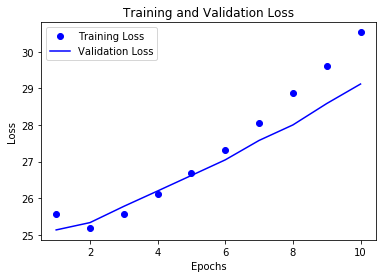

In [31]:
# Loss Curves
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

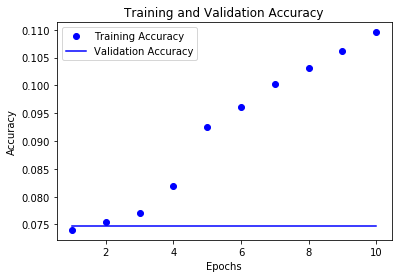

In [32]:
# Accuracy Curves
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that the Accuracy of the Deep Neural Network is insanely poor, straight from the first epoch. Most likely this is due to to to a small training set - neural networks are data-hungry, and a training set of around 6,000 records is not large enough. 

<br>
<br>

## Potential Next Steps ##

For further work on this project, we suggest the use of other methods, namely:

* A Bag of Words model with bigrams and trigrams
* A TF-IDF model with bigrams and trigrams
* An Averaged Word Vector model
* A TF-IDF Averaged Word Vectors model
* Collecting more data for the Deep Neural Network


<br>
<br>

## Thank You! ##